## Setting up: 

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import datetime

%load_ext autoreload
%autoreload 2

#additional functions: 
from add_functions.proj1_helpers import *
from add_functions.ml_methods_labs import *

### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

Note: 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [2]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
print(f'training data shape: y {y.shape}, X {tX.shape}')

training data shape: y (250000,), X (250000, 30)


In [4]:
y[:10], tX[:10,:2]

(array([ 1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.]),
 array([[ 138.47 ,   51.655],
        [ 160.937,   68.768],
        [-999.   ,  162.172],
        [ 143.905,   81.417],
        [ 175.864,   16.915],
        [  89.744,   13.55 ],
        [ 148.754,   28.862],
        [ 154.916,   10.418],
        [ 105.594,   50.559],
        [ 128.053,   88.941]]))

In [5]:
### standardize data:  
tX_std = standardize(tX)

#check if standardization method correct: 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(tX)
#print(scaler.transform(tX))

tX_std

array([[ 0.46141372,  0.06833197,  0.40768027, ...,  1.5668    ,
         1.55858439,  0.4125105 ],
       [ 0.51670419,  0.55250482,  0.54013641, ..., -0.63936657,
        -0.63936694, -0.27381996],
       [-2.33785898,  3.19515553,  1.09655998, ..., -0.63936657,
        -0.63936694, -0.29396985],
       ...,
       [ 0.38016991,  0.31931645, -0.13086367, ..., -0.63936657,
        -0.63936694, -0.31701723],
       [ 0.35431502, -0.84532397, -0.30297338, ..., -0.63936657,
        -0.63936694, -0.74543941],
       [-2.33785898,  0.66533608, -0.25352276, ..., -0.63936657,
        -0.63936694, -0.74543941]])

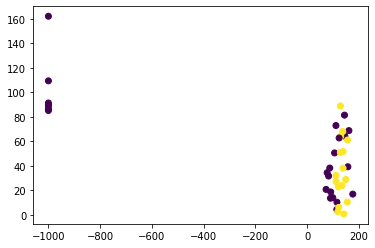

In [6]:
#Plot a few samples of first two coordinates:
NUM_POINTS = 40
plt.scatter(tX[:NUM_POINTS,0], tX[:NUM_POINTS,1], c = y[:NUM_POINTS])

In [7]:
import seaborn as sns
import pandas as pd

#sns.pairplot(pd.DataFrame(tX_std))

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Least Squares GD: 
Linear regression using gradient descent

In [240]:
def gradient_MSE(y, tx, w):
    return (-1 / len(y)) * tx.T @ (y - tx @ w)

In [241]:
def MSE_loss(y, tx, w):
    """Calculate the loss.
    You can calculate the loss using mse or mae.
    """
    MSE = np.square(np.subtract(y,tx@w)).mean()
    return MSE

In [242]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad = gradient_MSE(y, tx, w)
        loss = MSE_loss(y, tx, w)
        w -= gamma * grad
        # store w and loss:
        losses.append(loss)
        if n_iter%10 == 0:
            print("Least squares gradient Descent({bi}/{ti}): loss={l}".format(
                bi=n_iter, ti=max_iters - 1, l=loss))
    return w, losses, losses[-1]

Least squares gradient Descent(0/99): loss=1.0
Least squares gradient Descent(10/99): loss=0.9304690034359392
Least squares gradient Descent(20/99): loss=0.9005640052353776
Least squares gradient Descent(30/99): loss=0.8812402327377723
Least squares gradient Descent(40/99): loss=0.8677446947443402
Least squares gradient Descent(50/99): loss=0.8580286184137202
Least squares gradient Descent(60/99): loss=0.8508369618440981
Least squares gradient Descent(70/99): loss=0.8453557643729467
Least squares gradient Descent(80/99): loss=0.8410503624035713
Least squares gradient Descent(90/99): loss=0.8375665444536083


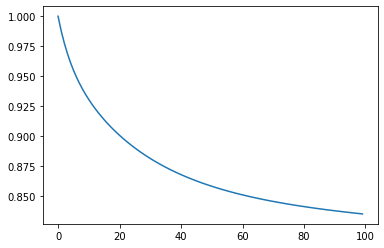

In [262]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 100
gamma = 0.01
w_ls_GD, losses_ls_GD, final_loss_ls_GD = least_squares_GD(
    y, tX_std, initial_w, max_iters, gamma)
plt.plot(losses_ls_GD)

In [244]:
from sklearn.metrics import mean_squared_error
#verify that MSE gives same error as MSE from sklearn:
mean_squared_error(y, tX_std @ w_ls_GD), MSE_loss(y, tX_std, w_ls_GD)

(0.7977829151289451, 0.7977829151289451)

### Least Squares SGD:
Linear regression using stochastic gradient descent

In [246]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    batch_size = 1
    """Stochastic gradient descent algorithm."""
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            grad = gradient_MSE(minibatch_y, minibatch_tx, w)
            loss = MSE_loss(minibatch_y, minibatch_tx, w)
            w -= gamma * grad
            # store w and loss
            losses.append(loss)
            if n_iter%10==0: 
                print("Least squares gradient Descent({bi}/{ti}): loss={l}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss))
    return w, losses, losses[-1]

Least squares gradient Descent(0/99): loss=1.0
Least squares gradient Descent(10/99): loss=0.9062785633803456
Least squares gradient Descent(20/99): loss=0.8569485739370216
Least squares gradient Descent(30/99): loss=0.6492113475811297
Least squares gradient Descent(40/99): loss=1.4652973157602671
Least squares gradient Descent(50/99): loss=1.413310700272229
Least squares gradient Descent(60/99): loss=0.6933734468226033
Least squares gradient Descent(70/99): loss=0.6422667444494594
Least squares gradient Descent(80/99): loss=0.7793782869409659
Least squares gradient Descent(90/99): loss=1.0191841810099158


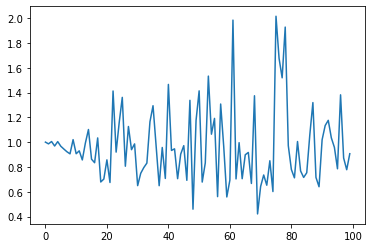

In [261]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 100
gamma = 0.001
w_ls_SGD, losses_ls_SGD, final_loss_ls_SGD = least_squares_SGD(y, tX_std, initial_w, max_iters,
                                         gamma)
plt.plot(losses_ls_SGD)

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [248]:
def least_squares(y, tX):
    w = np.linalg.solve(tX.T @ tX, tX.T @ y)
    loss = MSE_loss(y, tX, w)
    return w, loss

In [249]:
w_ls, loss_ls = least_squares(y, tX_std)
w_ls, loss_ls

(array([ 2.93788277e-02, -2.52531474e-01, -2.54791125e-01, -3.03696826e-02,
        -1.40144781e+00,  2.95701641e-01, -1.07889474e+01,  2.67880862e-01,
        -2.44934951e-03, -3.28854694e+02, -1.82647888e-01,  1.14039627e-01,
         2.05045969e+01,  6.38905957e+01, -3.18961844e-04, -1.80884303e-03,
         6.29996662e+01, -4.48641741e-04,  1.54379312e-03,  1.21462700e-01,
         3.95268515e-04, -6.33223483e-02, -2.06747091e-01, -1.16655759e-01,
         9.86256834e-02,  1.67907660e-01, -3.35146276e-02, -2.98358672e+00,
        -5.36388116e+00,  2.78501929e+02]),
 0.7779046298744752)

In [250]:
y_pred_ls = predict_labels(w_ls, tX_std)

### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [251]:
lambda_ = 0.02
def ridge_regression(y, tX, lambda_):
    w = np.linalg.solve(tX.T@tX+lambda_*np.eye(tX.shape[1]),tX.T@y)
    loss = MSE_loss(y, tX, w)
    return w, loss

In [252]:
w_rr, loss_rr = ridge_regression(y, tX_std,lambda_)
w_rr, loss_rr

(array([ 2.93666781e-02, -2.52530497e-01, -2.54823428e-01, -3.02099334e-02,
         8.53966995e-01,  2.92033690e-01, -1.01968078e+01,  2.67887607e-01,
        -2.52731682e-03, -3.50032924e-02, -1.82661485e-01,  1.14032110e-01,
         1.70868417e+01,  1.98775744e-01, -3.51306513e-04, -1.76418914e-03,
         2.94473957e-01, -4.74274957e-04,  1.59561206e-03,  1.21483014e-01,
         4.42749327e-04, -6.32331358e-02, -2.06402058e-01, -1.13409100e-01,
         1.05354901e-01,  1.57890918e-01, -1.44627398e-02, -2.74806187e+00,
        -5.04492362e+00, -4.45555753e-02]),
 0.777912229090242)

### Logistic regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

- cost : $J(w) = -1/m (-y^T log (h)-(1-y)^T log (1-h)) + \lambda/(2m)||w||^2 ; h = sigmoid(Xw)$

In [253]:
def sigmoid_activation(z):
    return 1.0 / (1 + np.exp(-z))

In [254]:
def cost_logistic(tX, y, w, lambda_):
    # Returns 1D array of probabilities that the class label == 1
    predictions = sigmoid_activation(tX@w)
    
    m = y.shape[0]
    #Take the sum of both costs: error when label=1 + error when label=0
    cost = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    #Take the average cost:
    cost = cost.sum() / m
    
    # regularizer:
    if lambda_:
        cost += (lambda_ / (2 * m)) * w.T @ w
    return cost

In [255]:
def update_weights_logistic(tX, y, w, lr, lambda_):
    m = tX.shape[0]
    #Get Predictions
    predictions = sigmoid_activation(np.dot(tX, w))

    # slope of the cost function across all observations
    gradient = 1/m * tX.T@(predictions - y)

    # if regularization
    if lambda_:
        gradient += 1/m * lambda_ * w

    # Subtract from our weights to minimize cost
    w -= lr * gradient
    return w

In [256]:
def train(tX, y, initial_w, lr, max_iters, lambda_=None):
    cost_history = []
    w = initial_w

    for i in range(max_iters):
        #Calculate error for auditing purposes
        cost = cost_logistic(tX, y, w, lambda_)
        cost_history.append(cost)

        w = update_weights_logistic(tX, y, w, lr, lambda_)

        # Log Progress:
        if i%10==0: 
            print(
                "Logistic regression gradient Descent({bi}/{ti}): loss={l}"
                .format(bi=i, ti=max_iters - 1, l=cost))

    return w, cost_history, cost_history[-1]

Logistic regression gradient Descent(0/299): loss=0.693147180559945
Logistic regression gradient Descent(10/299): loss=0.6411288109981919
Logistic regression gradient Descent(20/299): loss=0.6042585256615078
Logistic regression gradient Descent(30/299): loss=0.5760732091313302
Logistic regression gradient Descent(40/299): loss=0.5531511710861186
Logistic regression gradient Descent(50/299): loss=0.5336460967176516
Logistic regression gradient Descent(60/299): loss=0.5165191442532248
Logistic regression gradient Descent(70/299): loss=0.5011554066746111
Logistic regression gradient Descent(80/299): loss=0.48717042489755447
Logistic regression gradient Descent(90/299): loss=0.4743098653076913
Logistic regression gradient Descent(100/299): loss=0.46239586703860547
Logistic regression gradient Descent(110/299): loss=0.45129745285322875
Logistic regression gradient Descent(120/299): loss=0.44091370636236116
Logistic regression gradient Descent(130/299): loss=0.4311639046242928
Logistic regre

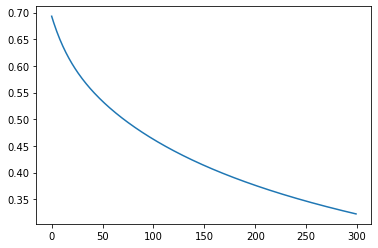

In [267]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 300
lr = 0.01
w_lr, losses_lr, final_loss_lr = train(tX, y, initial_w, lr, max_iters)
plt.plot(losses_lr)

### Regularized logistic regression
Regularized logistic regression using gradient descent or SGD. $ w^* = min_w \sum_{i=1}^n log(1+exp(-y_i w^T x_i)) +\lambda ‖w‖^2$

Logistic regression gradient Descent(0/99): loss=0.693147180559945
Logistic regression gradient Descent(10/99): loss=0.6561534327458004
Logistic regression gradient Descent(20/99): loss=0.6447889930900739
Logistic regression gradient Descent(30/99): loss=0.6410220265654998
Logistic regression gradient Descent(40/99): loss=0.6396937076525177
Logistic regression gradient Descent(50/99): loss=0.6392033532649114
Logistic regression gradient Descent(60/99): loss=0.6390164731526525
Logistic regression gradient Descent(70/99): loss=0.6389437189307859
Logistic regression gradient Descent(80/99): loss=0.6389149985255737
Logistic regression gradient Descent(90/99): loss=0.638903557667035


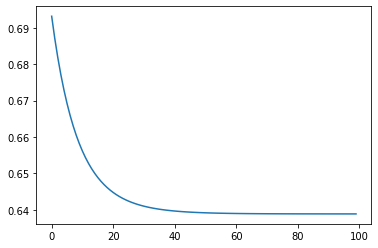

In [293]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 100
lr = 0.01
lambda_ = 1000000
w_lr_reg, losses_lr_reg, final_loss_lr_reg = train(tX, y, initial_w, lr, max_iters,
                                       lambda_)
plt.plot(losses_lr_reg)

## Generate predictions and save ouput in csv format for submission:

In [268]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

test data shape: X (568238, 30)


In [318]:
# standard par rapport à moyenne et std de train:
mean_train = np.mean(tX, axis=0)
std_train = np.std(tX - mean_train, axis=0)
test_data = standardize_with_meanstd(tX_test, mean_train, std_train)

In [326]:
weights_from_methods = {
    'LS_GD': w_ls_GD,
    'LS_SGD': w_ls_GD,
    'LS': w_ls,
    'RR': w_rr,
    'LR': w_lr,
    'LR_REG': w_lr_reg
}

# Choose method: 
METHOD = 'LR_REG'
test_prediction = predict_labels(weights_from_methods[METHOD], test_data)

OUTPUT_PATH = '../data/results/y_pred_' + METHOD + '.csv'
ids_test = pd.read_csv('../data/sample-submission.csv')['Id']
create_csv_submission(ids_test, y_pred__ls_GD, OUTPUT_PATH)